# Regressione con regolarizzazione, cross validation, grid search

**Pietro Pasini 0001081576**  

## Setup

Importare i package necessari e configurare l'output di matplotlib

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
from datetime import datetime
import time
import os
%matplotlib inline

In [2]:
def download_ilmeteo_data(cities, start_year, data_dir="weather_data"):
    
    BASE_URL = "https://www.ilmeteo.it/portale/archivio-meteo"
    
    MONTH_NAMES = {
        1: "Gennaio", 2: "Febbraio", 3: "Marzo", 4: "Aprile", 5: "Maggio", 6: "Giugno",
        7: "Luglio", 8: "Agosto", 9: "Settembre", 10: "Ottobre", 11: "Novembre", 12: "Dicembre"
    }

    today = datetime.today()
    end_year = today.year
    
    # Create data directory if it doesn't exist
    os.makedirs(data_dir, exist_ok=True)
    
    all_data = {city: {} for city in cities}

    # Columns to select and their new names
    COLUMNS_TO_KEEP = {
        'LOCALITA': 'localita',
        'DATA': 'data',
        'TMEDIA °C': 'tmedia',
        'TMIN °C': 'tmin',
        'TMAX °C': 'tmax'
    }

    for city in cities:
        print(f"--- Processing data for {city} ---")
        for year in range(start_year, end_year + 1):
            # Check if file already exists
            filename = f"{city}_{year}.csv"
            filepath = os.path.join(data_dir, filename)
            
            if os.path.exists(filepath):
                print(f"Loading existing data for {city} {year} from {filepath}")
                try:
                    year_df = pd.read_csv(filepath, index_col='data', parse_dates=['data'])
                    all_data[city][year] = year_df
                    print(f"Successfully loaded data for {city} for the year {year}.")
                    continue
                except Exception as e:
                    print(f"Error loading existing file {filepath}: {e}")
                    print(f"Will re-download data for {city} {year}")
            
            # Download data if file doesn't exist or failed to load
            print(f"Downloading data for {city} {year}")
            yearly_dfs = []
            
            last_month = today.month if year == end_year else 12
            
            for month in range(1, last_month + 1):
                month_name = MONTH_NAMES[month]
                url = f"{BASE_URL}/{city}/{year}/{month_name}?format=csv"
                
                try:
                    response = requests.get(url, timeout=10)
                    response.raise_for_status()
                    
                    csv_content = io.StringIO(response.text)
                    monthly_df = pd.read_csv(csv_content, sep=';')
                    
                    monthly_df.dropna(how='all', inplace=True)

                    if not monthly_df.empty and 'DATA' in monthly_df.columns:
                        # Filter for columns that exist in the dataframe
                        existing_cols = [col for col in COLUMNS_TO_KEEP if col in monthly_df.columns]
                        df_filtered = monthly_df[existing_cols].copy()
                        
                        # Rename columns
                        df_filtered.rename(columns=COLUMNS_TO_KEEP, inplace=True)

                        # Convert 'data' column to datetime objects
                        df_filtered['data'] = pd.to_datetime(df_filtered['data'], format='%d/%m/%Y', errors='coerce')
                        df_filtered.dropna(subset=['data'], inplace=True)

                        # Convert temperature columns to numeric
                        temp_cols_renamed = ['tmedia', 'tmin', 'tmax']
                        for col in temp_cols_renamed:
                            if col in df_filtered.columns:
                                # Replace comma with dot for decimal conversion and convert to numeric
                                df_filtered[col] = df_filtered[col].astype(str).str.replace(',', '.')
                                df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

                        if not df_filtered.empty:
                            yearly_dfs.append(df_filtered)
                    else:
                        print(f"Warning: No data or 'DATA' column found for {city}, {year}-{month_name}")

                except requests.exceptions.RequestException as e:
                    print(f"Error downloading data for {city}, {year}-{month_name}: {e}")
                
                time.sleep(0.5)

            if yearly_dfs:
                year_df = pd.concat(yearly_dfs, ignore_index=True)
                year_df.set_index('data', inplace=True)
                all_data[city][year] = year_df
                
                # Save to file
                try:
                    year_df.to_csv(filepath)
                    print(f"Successfully downloaded and saved data for {city} for the year {year} to {filepath}.")
                except Exception as e:
                    print(f"Error saving data to {filepath}: {e}")
            else:
                print(f"No data compiled for {city} for the year {year}.")

    return all_data

if __name__ == '__main__':
    CITIES_TO_DOWNLOAD = ["Milano", "Roma", "Palermo"]
    START_YEAR = 2020

    weather_data = download_ilmeteo_data(CITIES_TO_DOWNLOAD, START_YEAR)

--- Processing data for Milano ---
Successfully downloaded and saved data for Milano for the year 2020 to weather_data/Milano_2020.csv.
Successfully downloaded and saved data for Milano for the year 2021 to weather_data/Milano_2021.csv.
Successfully downloaded and saved data for Milano for the year 2022 to weather_data/Milano_2022.csv.
Successfully downloaded and saved data for Milano for the year 2023 to weather_data/Milano_2023.csv.
Successfully downloaded and saved data for Milano for the year 2024 to weather_data/Milano_2024.csv.
Successfully downloaded and saved data for Milano for the year 2025 to weather_data/Milano_2025.csv.
--- Processing data for Roma ---
Successfully downloaded and saved data for Roma for the year 2020 to weather_data/Roma_2020.csv.
Successfully downloaded and saved data for Roma for the year 2021 to weather_data/Roma_2021.csv.
Successfully downloaded and saved data for Roma for the year 2022 to weather_data/Roma_2022.csv.
Successfully downloaded and saved d

In [3]:
weather_data['Palermo'][2024].head(3)

,localita,tmedia,tmin,tmax
data,,,,
2024-01-01,Palermo,14.9,11.4,17.8
2024-01-02,Palermo,13.7,10.3,16.9
2024-01-03,Palermo,15.0,10.1,18.7


## Caso di studio: predizione consumo elettricità

Carichiamo i dati già visti nei laboratori precedenti: per ogni giorno degli anni dal 2015 al 2017 abbiamo la temperatura media in una città e il picco registrato di consumo di corrente elettrica

- con l'opzione `index_col` specifichiamo che la colonna `date` costituisce l'indice del DataFrame
- con `parse_dates` indichiamo che i suoi valori vanno interpretati come date

In [6]:
consumi2025 = pd.read_excel("TernaData/Export-DownloadCenterFile-20250626-180326.xlsx", index_col="Date", parse_dates=["Date"])

In [7]:
consumi2024 = pd.read_excel("TernaData/Export-DownloadCenterFile-20250626-182055.xlsx", index_col="Date", parse_dates=["Date"])

In [12]:
consumi2023 = pd.read_excel("TernaData/Export-DownloadCenterFile-20250626-181642.xlsx", index_col="Date", parse_dates=["Date"])

In [13]:
consumi2022 = pd.read_excel("TernaData/Export-DownloadCenterFile-20250626-182017.xlsx", index_col="Date", parse_dates=["Date"])

In [14]:
consumi2021 = pd.read_excel("TernaData/Export-DownloadCenterFile-20250626-182000.xlsx", index_col="Date", parse_dates=["Date"])

In [15]:
consumi2020 = pd.read_excel("TernaData/Export-DownloadCenterFile-20250626-181736.xlsx", index_col="Date", parse_dates=["Date"])

In [16]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday
from datetime import date
from astral import LocationInfo
from astral.sun import sun
import pytz

In [17]:
festività = [
    "01-01",  # Capodanno
    "01-06",  # Epifania
    "04-25",  # Festa della Liberazione
    "05-01",  # Festa del Lavoro
    "06-02",  # Festa della Repubblica
    "08-15",  # Ferragosto
    "11-01",  # Ognissanti
    "12-08",  # Immacolata
    "12-25",  # Natale
    "12-26",  # Santo Stefano
]
pasqua_date = [
    date(2020, 4, 12), date(2020, 4, 13),
    date(2021, 4, 4),  date(2021, 4, 5),
    date(2022, 4, 17), date(2022, 4, 18),
    date(2023, 4, 9),  date(2023, 4, 10),
    date(2024, 3, 31), date(2024, 4, 1),
    date(2025, 4, 20), date(2025, 4, 21),
]
# Funzione per determinare se una data è una festività
def is_festività(datetime):
    d = datetime.date()
    return int(d.strftime("%m-%d") in festività or d in pasqua_date)

In [18]:
city = LocationInfo(name='Roma', region='Italia', timezone='Europe/Rome',
                    latitude=41.9028, longitude=12.4964)

# Funzione per calcolare se un timestamp è in piena luce naturale
def is_daylight(timestamp):
    s = sun(city.observer, date=timestamp.date(), tzinfo=city.timezone)
    t = timestamp.tz_localize('Europe/Rome', ambiguous=False)
    return int(s['sunrise'] <= t <= s['sunset'])

In [19]:
consumi = [consumi2025, consumi2024, consumi2023, consumi2022, consumi2021, consumi2020]

In [20]:
for i in range(len(consumi)):
    c = consumi[i]
    # Elimina righe e colonne superflue
    c = c.drop(c.tail(2).index)
    c = c.drop(columns="Bidding Zone")

    c.index = pd.to_datetime(c.index)

    # --- Merge Weather Data ---
    year = c.index.year.unique()[0]
    for city_name in CITIES_TO_DOWNLOAD:
        if city_name in weather_data and year in weather_data[city_name]:
            weather_df_year = weather_data[city_name][year]
            
            # Select and rename temperature columns to be city-specific
            temp_cols = {
                'tmedia': f'tmedia_{city_name.lower()}',
                'tmin': f'tmin_{city_name.lower()}',
                'tmax': f'tmax_{city_name.lower()}'
            }
            weather_to_merge = weather_df_year[temp_cols.keys()].rename(columns=temp_cols)
            
            # Merge by date, forward-filling the daily weather data
            c = pd.merge_asof(c.sort_index(), weather_to_merge.sort_index(), left_index=True, right_index=True)
        else:
            print(f"Warning: No weather data found for {city_name} for the year {year}.")

    # Giorno dell’anno con ciclicità
    c['day_of_year_sin'] = np.sin(2 * np.pi * c.index.dayofyear / 366)
    c['day_of_year_cos'] = np.cos(2 * np.pi * c.index.dayofyear / 366)
    
    # Orario con ciclicità
    c['quarter_hour_sin'] = np.sin(2 * np.pi * (c.index.hour * 4 + c.index.minute // 15) / 96)
    c['quarter_hour_cos'] = np.cos(2 * np.pi * (c.index.hour * 4 + c.index.minute // 15) / 96)

    # Anno
    c['year'] = c.index.year
    
    # Festa nazionale
    c['holiday'] = c.index.map(is_festività)

    # Applica alla colonna datetime
    c['daylight'] = c.index.map(is_daylight)

    # One-hot encoding del giorno della settimana
    weekday_dummies = pd.get_dummies(c.index.weekday, prefix='weekday', drop_first=True)
    weekday_dummies.index = c.index
    c = pd.concat([c, weekday_dummies], axis=1)

    consumi[i] = c

In [21]:
consumi[0].head(5)

,Total Load [MW],Forecast Total Load [MW],tmedia_milano,tmin_milano,tmax_milano,tmedia_roma,tmin_roma,tmax_roma,tmedia_palermo,tmin_palermo,...,quarter_hour_cos,year,holiday,daylight,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,24928.999,24212.000,4.0,-2.0,8.0,7.0,3.0,13.0,11.8,9.1,...,1.000000,2025,1,0,False,True,False,False,False,False
2025-01-01 00:15:00,24885.999,24069.998,4.0,-2.0,8.0,7.0,3.0,13.0,11.8,9.1,...,0.997859,2025,1,0,False,True,False,False,False,False
2025-01-01 00:30:00,24675.000,24014.999,4.0,-2.0,8.0,7.0,3.0,13.0,11.8,9.1,...,0.991445,2025,1,0,False,True,False,False,False,False
2025-01-01 00:45:00,24506.999,23843.000,4.0,-2.0,8.0,7.0,3.0,13.0,11.8,9.1,...,0.980785,2025,1,0,False,True,False,False,False,False
2025-01-01 01:00:00,24186.001,23653.000,4.0,-2.0,8.0,7.0,3.0,13.0,11.8,9.1,...,0.965926,2025,1,0,False,True,False,False,False,False


In [22]:
X = pd.concat(consumi)
X['load_prev_day'] = X['Total Load [MW]'].shift(96)
X['load_prev_week'] = X['Total Load [MW]'].shift(672)
X = X.dropna(subset=['load_prev_day', 'load_prev_week'])

# Separate forecast values for dummy model
forecast_dummy = X['Forecast Total Load [MW]'].copy()

y = X[["Total Load [MW]"]]
X = X.drop(columns=["Total Load [MW]", 'Forecast Total Load [MW]'])


Vogliamo costruire un modello che consenta la predizione del consumo di corrente sulla base della temperatura in un qualsiasi giorno dell'anno

Come nello scorso laboratorio, suddividiamo i dati in

- un _training set_ `*_train` con i dati relativi all'anno 2015
- un _test set_ `*_test` con i dati relativi agli anni 2016 e 2017

Per ciascuno estraiamo

- una matrice `X_*` $N\times 1$ con le osservazioni delle variabili indipendenti: in questo caso una sola, la temperatura
- un vettore `y_*` con gli $N$ corrispondenti valori della variabile dipendente: i consumi

## Valutazione dei modelli

Abbiamo visto tre diverse metriche per la valutazione dell'accuratezza dei modelli di regressione

- l'_errore quadratico medio_, usato nella discesa del gradiente ma più difficilmente interpretabile
- l'_errore relativo_, noto in letteratura come _mean absoulte percentage error_ (MAPE), che indica intuitivamente la percentuale di errore del modello
- il _coefficiente R²_, che esprime l'accuratezza con un indice tra 0 e 1

Riprendiamo la funzione `print_eval` definita nella scorsa esercitazione per calcolare e stampare le tre metriche su un set di dati e un modello indicati

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def print_eval(X, y, model, y_scaler=None):
    preds = model.predict(X)
    if y_scaler is not None:
        preds = y_scaler.inverse_transform(preds.reshape(-1, 1))
    mse = mean_squared_error(y, preds)
    re = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    print(f"   Mean squared error: {mse:.5}")
    print(f"       Relative error: {re:.5%}")
    print(f"R-squared coefficient: {r2:.5}")

Riprendiamo anche la funzione `plot_model_on_data` per visualizzare un grafico del modello addestrato sovrapposto ai dati

In [24]:
def plot_model_on_data(X, y, model=None, figsize=(15, 5), y_scaler=None, title="Real vs Predicted"):
    plt.figure(figsize=figsize)

    # Valori reali
    plt.plot(y.index, y.values, label="Reale", color='black', alpha=0.6)

    # Se il modello è fornito, calcola e plotta le predizioni
    if model is not None:
        y_pred = model.predict(X)
        if y_scaler is not None:
            y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
        plt.plot(y.index, y_pred, label="Predetto", color='red', alpha=0.7)
        

    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel("Carico [MW]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Regolarizzazione e regressione ridge

Abbiamo visto come l'addestramento di un modello si compia minimizzando l'errore sui dati di addestramento, dato da

$$ E = \mathrm{media}\left(\left(\mathbf{X}\mathbf{\theta}-\mathbf{y}\right)^2\right) $$

Per l'esattezza, la formula su cui si basa `LinearRegression` è

$$ E = \left\Vert\mathbf{X}\mathbf{\theta}-\mathbf{y}\right\Vert_2^2 $$

Dove la _norma euclidea_ (o _norma 2_) $\left\Vert\mathbf{x}\right\Vert_2$ di un vettore $\mathbf{x}$ di $n$ elementi è

$$ \left\Vert\mathbf{x}\right\Vert_2 = \sqrt{\sum_{i=1}^n x_i^2} = \sqrt{x_1^2+\ldots+x_n^2} $$

Tuttavia, questo non garantisce l'accuratezza del modello in generale

Soprattutto se il modello ha molti parametri, è possibile che questi vengano "forzati" a funzionare bene sui dati d'addestramento, rendendo però il modello poco accurato in generale

In [25]:
# sono eseguiti quì tutti gli import necessari da scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [26]:
is_train = X.index.year < 2025
X_train = X[is_train]
y_train = y[is_train]
X_test = X[~is_train]
y_test = y[~is_train]

X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

In [27]:
# Create dummy model that returns the forecast values
class ForecastDummyModel:
    def __init__(self, forecast_values):
        # Split forecast values according to train/test indices
        self.forecast_train = forecast_values[is_train]
        self.forecast_test = forecast_values[~is_train]
    
    def fit(self, X, y):
        # Dummy model doesn't need training
        return self
    
    def predict(self, X):
        # Determine if we're predicting on train or test set based on X shape/indices
        if len(X) == len(X_train):
            return self.forecast_train.values.reshape(-1, 1)
        elif len(X) == len(X_test):
            return self.forecast_test.values.reshape(-1, 1)
        else:
            # For other cases, try to match indices
            if hasattr(X, 'index'):
                matched_forecasts = forecast_dummy.loc[X.index]
                return matched_forecasts.values.reshape(-1, 1)
            else:
                raise ValueError("Cannot determine which forecast values to return")

# Create and evaluate the dummy model
dummy_model = ForecastDummyModel(forecast_dummy)
dummy_model.fit(X_train, y_train)

print("=== DUMMY MODEL EVALUATION (Data Provider Forecast) ===")
print("Training set performance:")
print_eval(X_train, y_train, dummy_model)
print("\nTest set performance:")
print_eval(X_test, y_test, dummy_model)

=== DUMMY MODEL EVALUATION (Data Provider Forecast) ===
Training set performance:
   Mean squared error: 9.6793e+05
       Relative error: 2.15445%
R-squared coefficient: 0.9859

Test set performance:
   Mean squared error: 5.7438e+05
       Relative error: 1.62069%
R-squared coefficient: 0.99087


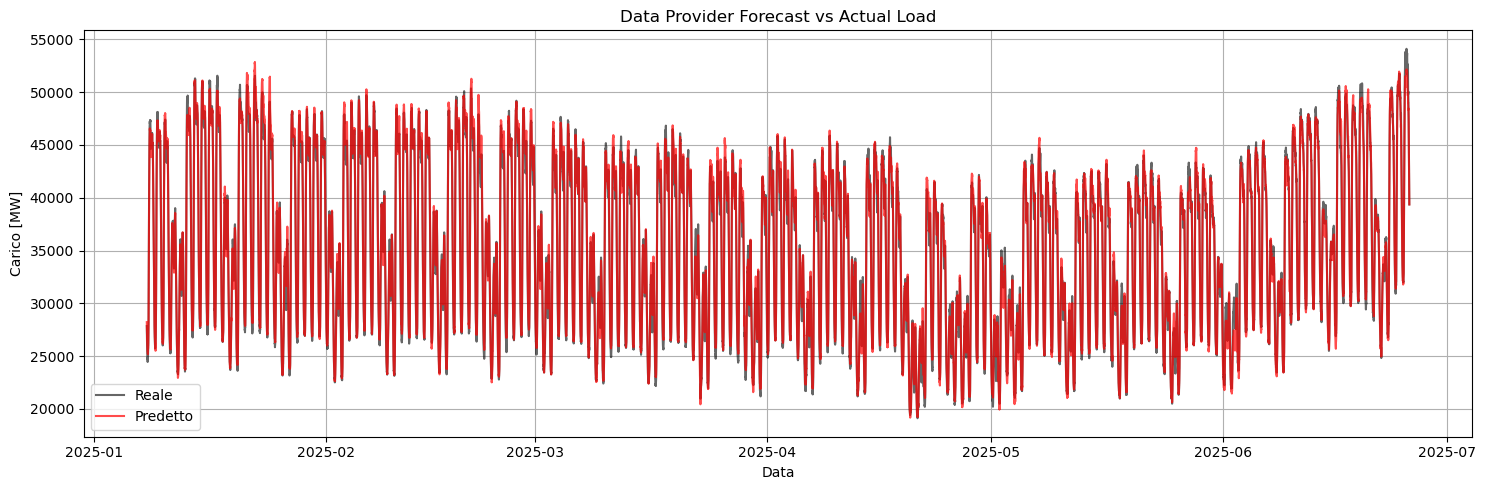

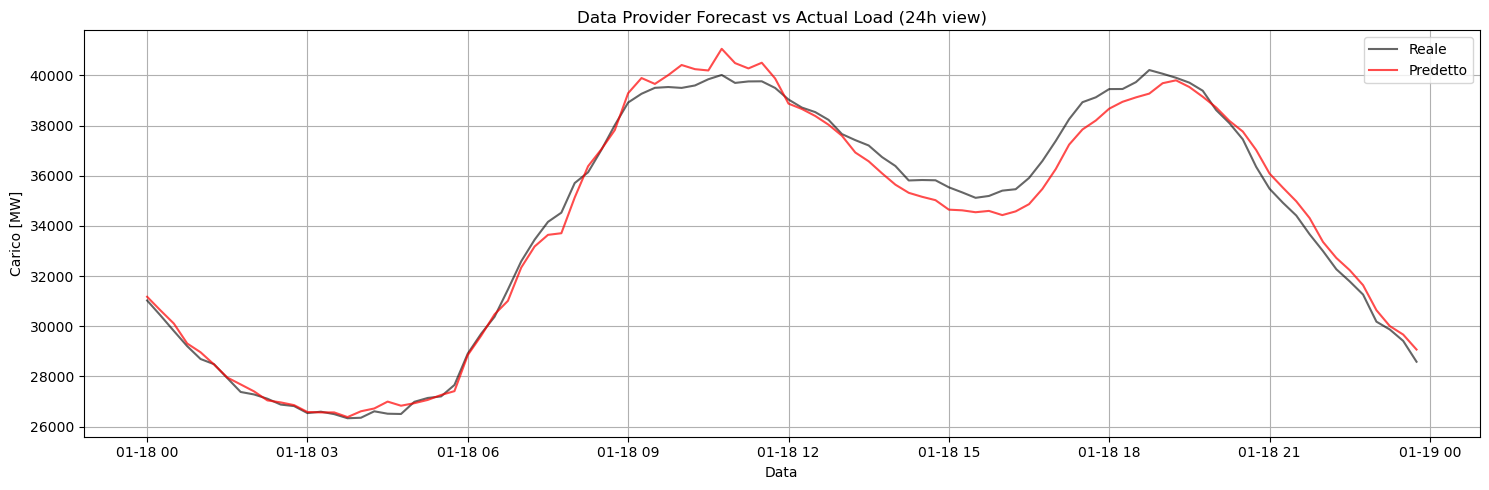

In [28]:
# Visualize dummy model performance
plot_model_on_data(X_test, y_test, dummy_model, title="Data Provider Forecast vs Actual Load")

# Show a zoomed view for better detail
plot_model_on_data(X_test[960:1056], y_test[960:1056], dummy_model, title="Data Provider Forecast vs Actual Load (24h view)")

In [29]:
model_lasso = Lasso(alpha=0.001, max_iter=10000)
model_lasso.fit(X_train_scaled, y_train_scaled)

,alpha,0.001
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,10000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [30]:
print_eval(X_test_scaled, y_test, model_lasso, y_scaler)

np.abs(pd.DataFrame(
    model_lasso.coef_,
    index=X_train.columns,
    columns=["Coefficiente"]
)).sort_values(by="Coefficiente")


   Mean squared error: 5.1063e+06
       Relative error: 4.74905%
R-squared coefficient: 0.91881


,Coefficiente
tmin_milano,0.000000
tmedia_palermo,0.000000
daylight,0.000000
tmin_roma,0.000476
year,0.003280
day_of_year_cos,0.007002
day_of_year_sin,0.011857
tmax_milano,0.016102
tmax_palermo,0.025129
tmin_palermo,0.028955


In [167]:
X_train = X_train.drop(columns=['tmin_milano', "tmedia_palermo","daylight"])
X_test = X_test.drop(columns=["tmin_milano", "tmedia_palermo","daylight"])
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

KeyError: "['tmin_milano', 'tmedia_palermo', 'daylight'] not found in axis"

In [31]:
X_train.head(3)
X_test.head(3)

,tmedia_milano,tmin_milano,tmax_milano,tmedia_roma,tmin_roma,tmax_roma,tmedia_palermo,tmin_palermo,tmax_palermo,day_of_year_sin,...,holiday,daylight,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,load_prev_day,load_prev_week
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-08 00:00:00,5.0,5.0,6.0,12.0,7.0,15.0,14.5,10.2,17.4,0.136906,...,0,0,False,True,False,False,False,False,23789.999,24928.999
2025-01-08 00:15:00,5.0,5.0,6.0,12.0,7.0,15.0,14.5,10.2,17.4,0.136906,...,0,0,False,True,False,False,False,False,23146.000,24885.999
2025-01-08 00:30:00,5.0,5.0,6.0,12.0,7.0,15.0,14.5,10.2,17.4,0.136906,...,0,0,False,True,False,False,False,False,22661.999,24675.000


In [32]:
model_a = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scale", StandardScaler()),
    ("linreg", Ridge(alpha=0.001))
])
model_a.fit(X_train, y_train_scaled)
print_eval(X_test, y_test, model_a, y_scaler)

   Mean squared error: 2.2879e+06
       Relative error: 3.35189%
R-squared coefficient: 0.96362


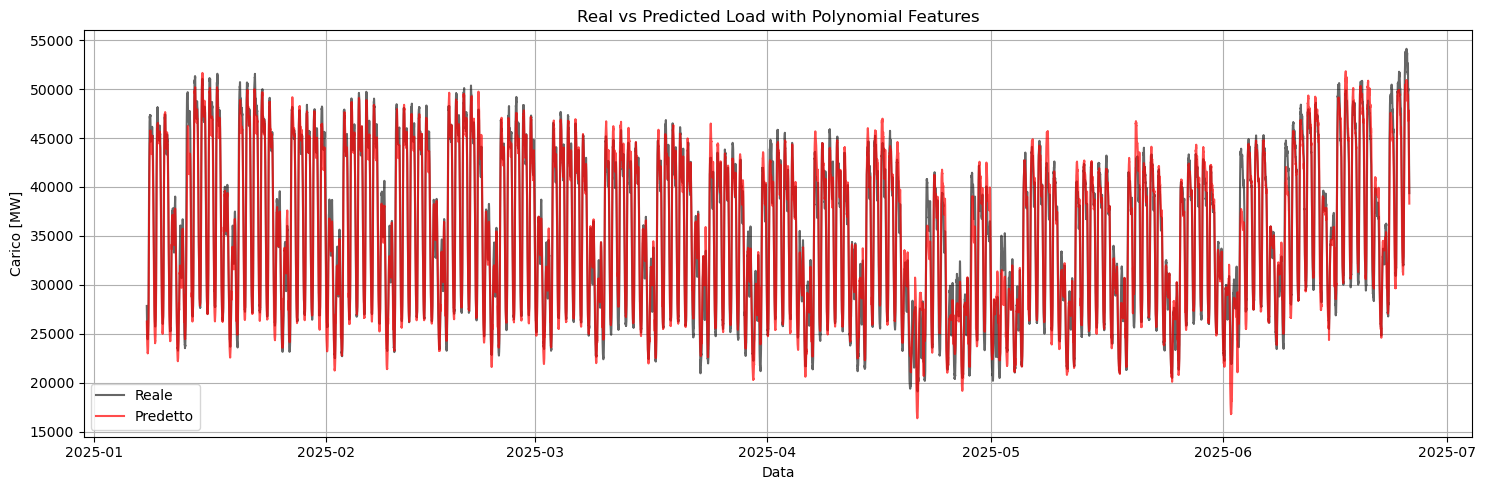

In [33]:
plot_model_on_data(X_test, y_test, model_a, y_scaler=y_scaler, title="Real vs Predicted Load with Polynomial Features")

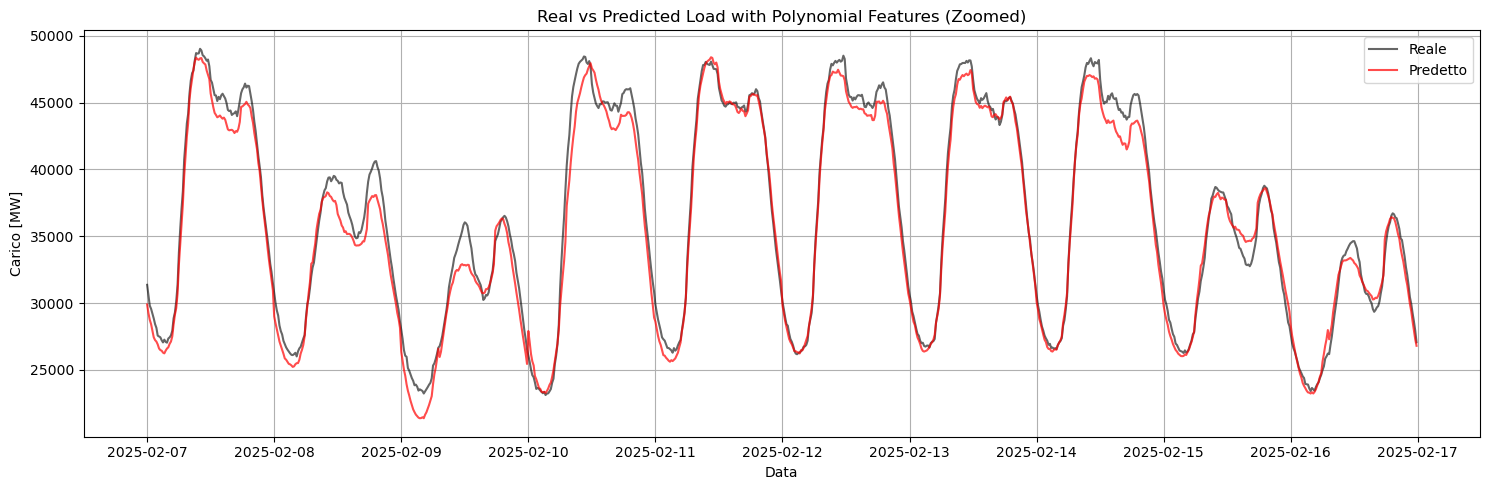

In [34]:
plot_model_on_data(X_test[2880:3840], y_test[2880:3840], model_a, y_scaler=y_scaler, title="Real vs Predicted Load with Polynomial Features (Zoomed)")

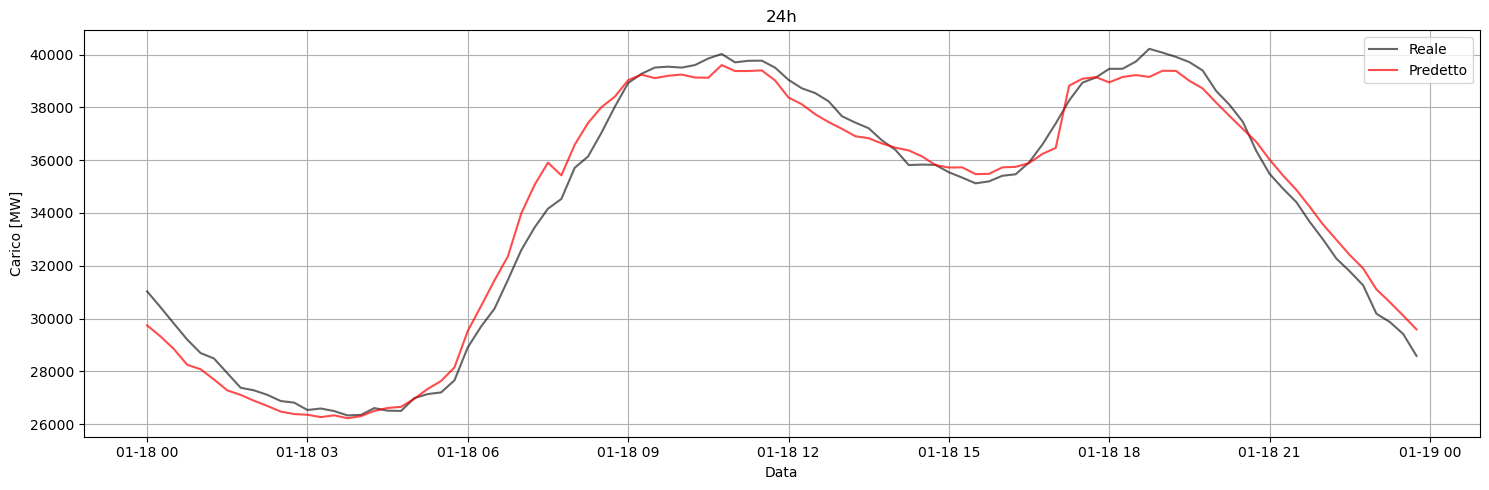

In [36]:
plot_model_on_data(X_test[960:1056], y_test[960:1056], model_a, y_scaler=y_scaler, title="24h")

Si nota che nei casi estremi del test set, diversi da quelli del training set, l'errore del modello è molto alto

Vediamo quali sono i coefficienti del modello addestrato

### Analisi coefficienti dei modelli

Visualizziamo ora in un unico frame i coefficienti di tutti e tre i modelli (una riga per variabile, una colonna per modello)

In [37]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=1/3, random_state=42)

In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2

2025-06-30 10:00:56.206011: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 10:00:56.212026: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751270456.219363   32289 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751270456.222002   32289 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751270456.228657   32289 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [39]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [40]:
mlp_model = Sequential([
    Input((X_train.shape[1],)),
    Dense(1024, activation="relu", kernel_regularizer=l2(0.1)),
    Dense(512, activation="relu"),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1),
])
mlp_model.compile(optimizer="adam", loss="mean_squared_error")
mlp_model.summary()

I0000 00:00:1751270458.098135   32289 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3507 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,225 (2.37 MB)

 Trainable params: 620,225 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
mlp_model.fit(X_train_scaled, y_train_scaled, epochs=24, batch_size=512)

Epoch 1/24


I0000 00:00:1751270460.699060   32599 service.cc:152] XLA service 0x7f60c000a680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751270460.699070   32599 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-06-30 10:01:00.715380: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751270460.803095   32599 cuda_dnn.cc:529] Loaded cuDNN version 91002


 92/343 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5472

I0000 00:00:1751270461.581134   32599 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1432
Epoch 2/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0472
Epoch 3/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0417
Epoch 4/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0340
Epoch 5/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0304
Epoch 6/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0272
Epoch 7/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0255
Epoch 8/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0256
Epoch 9/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0239
Epoch 10/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0232
Epoch 11/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0227
Epoch 12/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0225
Epoch 13/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0210
Epoch 14/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0210
Epoch 15/24
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0209


In [42]:
print_eval(X_train_scaled, y_train, mlp_model, y_scaler)
print_eval(X_test_scaled, y_test, mlp_model, y_scaler)
print_eval(X_test, y_test, dummy_model)

5481/5481 ━━━━━━━━━━━━━━━━━━━━ 3s 527us/step
   Mean squared error: 8.9731e+05
       Relative error: 2.07802%
R-squared coefficient: 0.98693
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step
   Mean squared error: 1.1272e+06
       Relative error: 2.36248%
R-squared coefficient: 0.98208
   Mean squared error: 5.7438e+05
       Relative error: 1.62069%
R-squared coefficient: 0.99087


507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


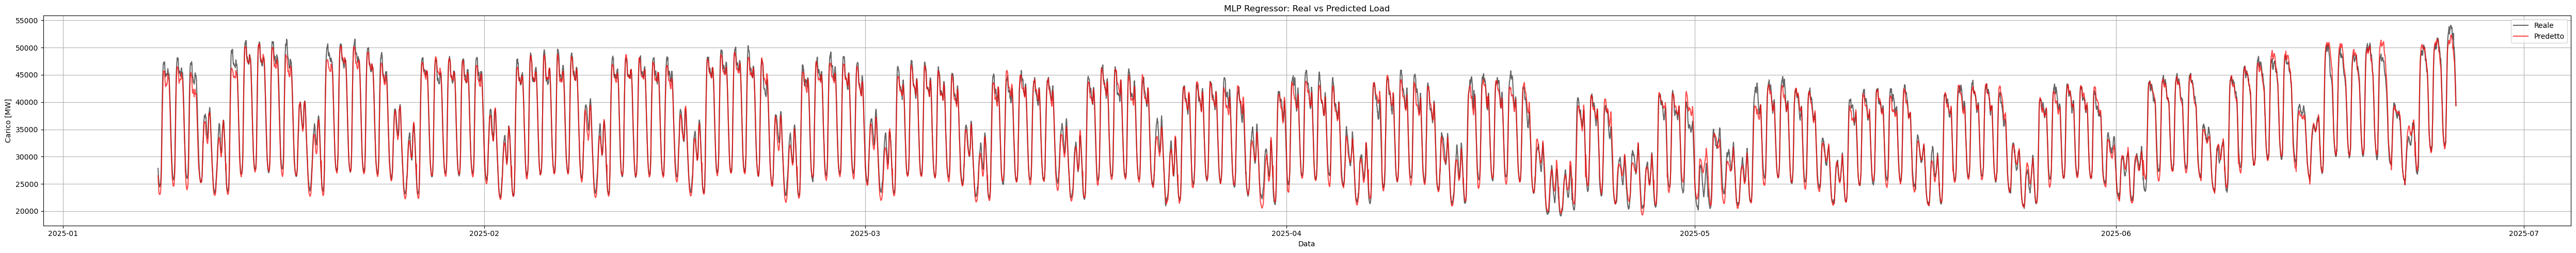

In [43]:
plot_model_on_data(X_test_scaled, y_test, mlp_model, figsize=(50, 5),y_scaler=y_scaler, title="MLP Regressor: Real vs Predicted Load")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


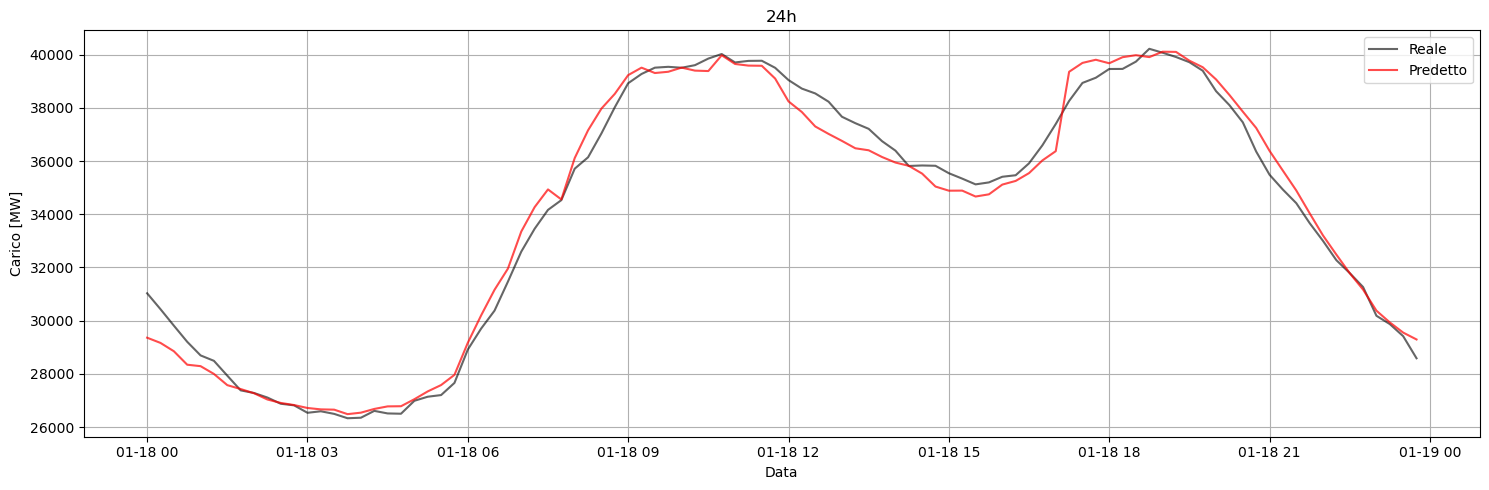

In [44]:
plot_model_on_data(X_test_scaled[960:1056], y_test[960:1056], mlp_model, y_scaler=y_scaler, title="24h")

## k-Fold Cross Validation

La _cross validation_ si riferisce in generale alla valutazione di un modello di predizione su dati differenti rispetto a quelli su cui è addestrato

La cross validation prevede in generale di generare diverse suddivisioni dei dati in _training set_ e _validation set_ e per ciascuna addestrare un modello sul primo e misurare le metriche di accuratezza sul secondo

Finora abbiamo usato il semplice metodo _hold-out_, dove viene effettuata una singola suddivisione dei dati con proporzioni configurabili

_k-fold_ è un metodo comune per eseguire una valutazione più accurata del modello

- i dati sono divisi causalmente in k gruppi (_fold_)
- ciascun gruppo è usato come test set di un modello addestrato su tutti gli altri gruppi
- i risultati dei singoli test sono aggregati

scikit-learn fornisce un supporto generico per la cross-validation di modelli tramite diversi metodi

Per prima cosa va creato un oggetto che definisce il metodo di cross-validation da applicare

Usiamo ad esempio un oggetto della classe `KFold`

- il primo parametro è il numero di fold (k) da usare
- specifichiamo inoltre che i dati sono distribuiti casualmente e il seed da usare

In [108]:
from sklearn.model_selection import KFold
kfold_5 = KFold(5, shuffle=True, random_state=42)

Gli oggetti di questo tipo forniscono un metodo `split`, che dato un dataset genera le suddivisioni training/test secondo la configurazione data

Per ogni suddivisione sono dati un array di etichette delle righe da includere nel training set (`train_index`) e l'array complementare di etichette delle righe da includere nel validation set (`val_index`)

In [109]:
for i, (train_index, val_index) in enumerate(kfold_5.split(X, y), start=1):
    print(f"Fold {i}: {len(train_index)} istanze di training, {len(val_index)} istanze di validazione")
    # per ottenere ad es. X_train: X[train_index]

Fold 1: 153289 istanze di training, 38323 istanze di validazione
Fold 2: 153289 istanze di training, 38323 istanze di validazione
Fold 3: 153290 istanze di training, 38322 istanze di validazione
Fold 4: 153290 istanze di training, 38322 istanze di validazione
Fold 5: 153290 istanze di training, 38322 istanze di validazione


Definiamo la configurazione di un modello da validare, ad es. un modello di regressione lineare

In [110]:
model = LinearRegression()

Per eseguire la CV usiamo quindi la funzione `cross_validate`, a cui passiamo in input:

- la definizione di un modello, di cui viene addestrata una copia con la stessa configurazione per ciascun fold
- i dati, divisi come per `fit` in valori di variabili indipendenti (X) e dipendente (y)
- un oggetto `cv` che definisce il metodo di cross validation, in questo caso l'istanza di `KFold`
- l'opzione `return_train_score=True` per eseguire la valutazione anche sul training set di ciascun fold

In [111]:
from sklearn.model_selection import cross_validate
cv_result = cross_validate(model, X, y, cv=kfold_5, return_train_score=True)

Otteniamo un dizionario con un vettore per ciascuna misura estratta, ciascuno ha un valore per ogni fold

In [112]:
cv_result

{'fit_time': array([0.08215618, 0.0732429 , 0.07403541, 0.07354045, 0.07427096]),
 'score_time': array([0.0029676 , 0.00290012, 0.00281644, 0.0028193 , 0.00281334]),
 'test_score': array([0.90584319, 0.9068061 , 0.90767245, 0.90938567, 0.90597102]),
 'train_score': array([0.90750548, 0.90726729, 0.90705067, 0.90660999, 0.9074704 ])}

Per maggiore comodità raccogliamo i dati in un DataFrame

In [113]:
cv_table = pd.DataFrame(cv_result)
cv_table

,fit_time,score_time,test_score,train_score
0,0.082156,0.002968,0.905843,0.907505
1,0.073243,0.002900,0.906806,0.907267
2,0.074035,0.002816,0.907672,0.907051
3,0.073540,0.002819,0.909386,0.906610
4,0.074271,0.002813,0.905971,0.907470


Per ognuno dei 5 fold vediamo riportati

- i secondi impiegati per l'addestramento (`fit_time`) e la validazione (`score_time`) del modello
- il punteggio calcolato su training set (`train_score`) e validation set (`test_score`)

Il punteggio è quello calcolato dal metodo `score` del modello, ovvero il coefficiente R²

Per avere un dato generale sulla bontà del modello, possiamo calcolare media e deviazione standard dei punteggi

In [114]:
cv_table[["train_score", "test_score"]].agg(["mean", "std"])

,train_score,test_score
mean,0.907181,0.907136
std,0.000367,0.001457


Tale valutazione è più affidabile di quella col metodo hold-out, ottenuta da un singolo modello

Ci permette inoltre di valutare la "robustezza" del modello, ovvero quanto l'accuratezza sia stabile addestrandosi su set di dati diversi

### Esercizio 6: Cross-validation

- **(6a)** Definire un modello di regressione polinomiale ridge di 3° grado su feature standardizzate con $\alpha=10$
- **(6b)** Eseguire la cross-validation del modello, utilizzando 5 fold dell'intero dataset `housing` (`X` e `y`) generati dall'oggetto `kfold_5` definito sopra
- **(6c)** Calcolare la media e la deviazione standard dei punteggi R² ottenuti dalla validazione di ciascun fold

## Ricerca degli iperparametri con grid search

Sui modelli utilizzati finora abbiamo impostato manualmente i valori di diversi iperparametri: grado della regressione polinomiale, peso della regolarizzazione, ...

L'accuratezza del modello può dipendere fortemente da questi valori

Scelto un generico modello da utilizzare (es. regressione polinomiale), vorremmo **individuare i valori degli iperparametri che ne massimizzino l'accuratezza**

scikit-learn fornisce un supporto per eseguire automaticamente la cross validation di un modello con diversi valori degli iperparametri tramite la _grid search_

Consideriamo ad esempio un modello _elastic net_ di cui fissiamo arbitrariamente l'iperparametro `l1_ratio`

In [115]:
model = ElasticNet(l1_ratio=0.2)

NameError: name 'ElasticNet' is not defined

Vorremmo trovare il migliore valore possibile dell'iperparametro `alpha` tra un insieme di valori possibili, ovvero:

In [ ]:
candidate_alphas = [0.1, 1, 10]

Creiamo una _griglia_ degli iperparametri, ovvero un dizionario in cui associamo ai nomi degli iperparametri variabili i valori che possono assumere

In questo caso abbiamo un unico parametro variabile, `alpha`

In [ ]:
grid = {"alpha": candidate_alphas}

Definiamo ora un modello `GridSearchCV` indicando

- il modello "base" con i parametri fissati a priori
- la griglia dei parametri variabili
- un metodo `cv` di cross validation da usare

In [ ]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(model, grid, cv=kfold_5)

Come per i modelli base, usiamo il metodo `fit` per eseguire l'addestramento, passando la matrice X e il vettore y

Per ogni valore possibile di `alpha`, scikit-learn esegue la cross-validation per calcolare il punteggio R² medio del modello con quel valore di `alpha`

In [ ]:
gs.fit(X_train, y_train);

In seguito ai test, il modello impostato viene (di default) riaddestrato su tutti i dati forniti, usando gli iperparametri che han dato il miglior punteggio medio

Il modello finale è accessibile all'attributo `gs_best_estimator_`

In [ ]:
gs.best_estimator_

ElasticNet(alpha=0.1, l1_ratio=0.2)

Dall'attributo `best_params_` possiamo vedere quali sono i valori selezionati dalla griglia degli iperparametri per tale modello

In [ ]:
gs.best_params_

{'alpha': 0.1}

L'oggetto `GridSearchCV` addestrato può essere usato come un normale modello di predizione, le chiamate a `predict` e altri metodi sono girate al `best_estimator_`

In [ ]:
# prezzo predetto per la prima riga del dataset
gs.predict(X.iloc[[0]])

array([31.03112487])

In [ ]:
# equivalente a
gs.best_estimator_.predict(X.iloc[[0]])

array([31.03112487])

Possiamo infine valutare il modello sul test set, non utilizzato nella grid search

In [ ]:
print_eval(X_test, y_test, gs)

   Mean squared error: 21.905
       Relative error: 16.80121%
R-squared coefficient: 0.7088


L'attributo `cv_results_` fornisce risultati dettagliati su tutti gli iperparametri testati

Come per `cross_validate`, raccogliamo i risultati in un `DataFrame` per visualizzarli meglio

In [ ]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002926,0.000382,0.001901,0.000423,0.1,{'alpha': 0.1},0.727252,0.496850,0.637157,0.721205,0.800228,0.676539,0.103639,1
1,0.002289,0.000302,0.001546,0.000184,1.0,{'alpha': 1},0.714022,0.523966,0.594603,0.670194,0.761741,0.652905,0.084740,2
2,0.002254,0.000293,0.001487,0.000160,10.0,{'alpha': 10},0.624769,0.373641,0.572294,0.539693,0.623149,0.546709,0.092296,3


I dati riportati per ciascun test includono:
- `{mean|std}_{fit|score}_time`: media/dev. standard dei tempi di addestramento/valutazione sui diversi fold
- `param_X`: valore del parametro X
- `params`: dizionario col valore di tutti i parametri
- `splitN_test_score`: punteggio della valutazione sull'N-esimo fold
- `{mean|std}_test_score`: media/dev. standard dei punteggi sui diversi fold
- `rank_test_score`: ranking del punteggio, 1 è il migliore

Cosa succede con due iperparametri variabili?

Oltre a 3 valori possibili per `alpha`, impostiamo 3 valori possibili anche per `l1_ratio`

In [ ]:
model = ElasticNet()
grid = {
    "alpha":    [0.1, 1, 10],
    "l1_ratio": [0.1, 0.2, 0.3]
}
gs = GridSearchCV(model, grid, cv=kfold_5)
gs.fit(X_train, y_train);

Visualizzo i risultati ordinati per punteggio R² medio decrescente

In [ ]:
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001534,0.000323,0.000945,0.000197,0.1,0.1,"{'alpha': 0.1, 'l1_ratio': 0.1}",0.727791,0.499753,0.636757,0.721171,0.800223,0.677139,0.102714,1
1,0.001457,0.000275,0.000900,0.000154,0.1,0.2,"{'alpha': 0.1, 'l1_ratio': 0.2}",0.727252,0.496850,0.637157,0.721205,0.800228,0.676539,0.103639,2
2,0.001212,0.000111,0.000823,0.000113,0.1,0.3,"{'alpha': 0.1, 'l1_ratio': 0.3}",0.726624,0.493642,0.637503,0.721081,0.800186,0.675807,0.104646,3
3,0.001424,0.000421,0.000952,0.000218,1.0,0.1,"{'alpha': 1, 'l1_ratio': 0.1}",0.714960,0.526437,0.595148,0.670794,0.763423,0.654152,0.084507,4
4,0.001192,0.000135,0.000845,0.000113,1.0,0.2,"{'alpha': 1, 'l1_ratio': 0.2}",0.714022,0.523966,0.594603,0.670194,0.761741,0.652905,0.084740,5
5,0.001384,0.000140,0.000974,0.000232,1.0,0.3,"{'alpha': 1, 'l1_ratio': 0.3}",0.714237,0.521933,0.594699,0.669538,0.759777,0.652037,0.084850,6
6,0.001352,0.000233,0.001111,0.000297,10.0,0.1,"{'alpha': 10, 'l1_ratio': 0.1}",0.638007,0.397883,0.577252,0.557198,0.655982,0.565264,0.091374,7
7,0.001579,0.000239,0.001297,0.000295,10.0,0.2,"{'alpha': 10, 'l1_ratio': 0.2}",0.624769,0.373641,0.572294,0.539693,0.623149,0.546709,0.092296,8
8,0.001479,0.000191,0.000963,0.000225,10.0,0.3,"{'alpha': 10, 'l1_ratio': 0.3}",0.614417,0.357906,0.570172,0.529856,0.607627,0.535995,0.094024,9


scikit-learn ha generato e testato **tutte le combinazioni possibili** dei valori degli iperparametri, in tutto 3×3 = 9 configurazioni

### Grid search su pipeline

Possiamo usare `GridSearchCV` anche con una pipeline testando diversi valori per gli iperparametri di tutti i componenti, sia modello che filtri

Consideriamo ad esempio il seguente modello polinomiale con regolarizzazione L2, su cui sono variabili

- il grado del polinomio (attributo `degree` del filtro `poly`)
- il peso della regolarizzazione (attributo `alpha` del modello `regr`)

In [ ]:
model = Pipeline([
    ("poly",  PolynomialFeatures(include_bias=False)),
    ("scale", StandardScaler()),
    ("regr",  Ridge())
])

Per riferirsi ai parametri dei singoli componenti, usiamo la notazione `componente__parametro` _(con DUE underscore in mezzo)_

In [ ]:
grid = {
    # grado polinomio (parametro "degree" del filtro "poly")
    "poly__degree": [2, 3],
    # peso regolarizzazione (parametro "alpha" del modello "regr")
    "regr__alpha":  [0.1, 1, 10],
}

Il resto del procedimento rimane invariato

In [ ]:
gs = GridSearchCV(model, grid, cv=kfold_5)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_regr__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.004421,0.001015,0.001820,0.000196,2,1.0,"{'poly__degree': 2, 'regr__alpha': 1}",0.835447,0.596491,0.802240,0.810611,0.882463,0.785450,0.098521,1
2,0.003450,0.000132,0.001603,0.000044,2,10.0,"{'poly__degree': 2, 'regr__alpha': 10}",0.842239,0.594859,0.750900,0.795789,0.856246,0.768007,0.094172,2
0,0.005146,0.000990,0.002677,0.000153,2,0.1,"{'poly__degree': 2, 'regr__alpha': 0.1}",0.824409,0.648065,0.850516,0.816894,0.493138,0.726604,0.136929,3
5,0.051488,0.026883,0.003045,0.000165,3,10.0,"{'poly__degree': 3, 'regr__alpha': 10}",0.853895,0.454814,0.773790,0.748621,0.333358,0.632895,0.201753,4
4,0.020466,0.010404,0.002819,0.000223,3,1.0,"{'poly__degree': 3, 'regr__alpha': 1}",0.852441,0.568150,0.794898,0.775824,-3.047350,-0.011207,1.521113,5
3,0.010790,0.001641,0.002584,0.000132,3,0.1,"{'poly__degree': 3, 'regr__alpha': 0.1}",0.692042,0.664729,0.648950,0.784034,-3.348237,-0.111696,1.618947,6


Nella pipeline possiamo impostare un intero componente come parametro variabile, con la possibilità di rimuoverlo impostandolo a `None`

Possiamo ad esempio testare un modello con e senza standardizzazione delle feature

In [ ]:
model = Pipeline([
    ("scale", None),   # uso None come segnaposto
    ("regr",  Ridge())
])
grid = {
    # scale = standardizzazione oppure nulla
    "scale": [None, StandardScaler()],
    "regr__alpha": [0.1, 1, 10]
}
gs = GridSearchCV(model, grid, cv=kfold_5)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regr__alpha,param_scale,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.002131,0.000218,0.000969,0.000036,1.0,StandardScaler(),"{'regr__alpha': 1, 'scale': StandardScaler()}",0.735767,0.495302,0.657167,0.720101,0.800925,0.681853,0.103883,1
1,0.003808,0.000443,0.001904,0.000164,0.1,StandardScaler(),"{'regr__alpha': 0.1, 'scale': StandardScaler()}",0.735121,0.495993,0.656523,0.720110,0.801136,0.681776,0.103648,2
5,0.002284,0.000332,0.001078,0.000103,10.0,StandardScaler(),"{'regr__alpha': 10, 'scale': StandardScaler()}",0.741449,0.487396,0.662300,0.718528,0.798668,0.681668,0.106525,3
0,0.002748,0.000380,0.001808,0.000226,0.1,None,"{'regr__alpha': 0.1, 'scale': None}",0.734675,0.494498,0.655446,0.718577,0.801852,0.681009,0.104244,4
2,0.002207,0.000064,0.001600,0.000131,1.0,None,"{'regr__alpha': 1, 'scale': None}",0.730686,0.487010,0.649269,0.712555,0.801934,0.676291,0.106412,5
4,0.001205,0.000033,0.000864,0.000079,10.0,None,"{'regr__alpha': 10, 'scale': None}",0.726584,0.488528,0.641675,0.719819,0.801424,0.675606,0.106333,6


### Esercizio 7: Grid search

Si consideri un modello di regressione polinomiale elastic net con standardizzazione delle feature generate. Vogliamo testare tutte le possibili combinazioni dei seguenti parametri:

- grado 2 o 3
- `alpha` pari a 0.1, 1 o 10
- `l1_ratio` pari a 0.1, 0.25 o 0.5

Eseguire una grid search con cross-validation a 5 fold sul training set, stampare gli iperparametri migliori selezionati dalla grid search e stampare le misure di accuratezza del modello migliore sul test set

## Nested cross-validation

Sopra abbiamo validato il risultato finale della grid search su un test set separato

La _nested cross-validation_ prevede che siano generati **k fold "esterni"** su tutti i dati disponibili e che **per ciascuno** si esegua il tuning degli iperparametri con una cross validation "interna" usando le parti di training dei fold esterni

I criteri con cui si eseguono le cross validation esterna ed interna possono differire, es. diverso numero di fold

Ipotizziamo ad esempio di usare 3 fold esterni e 5 interni

In [ ]:
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)

### Esercizio 8 (avanzato): Nested cross validation

**(8a)** Completare l'implementazione una funzione `nested_cv` che esegua la nested cross validation di un modello `model` con griglia di parametri variabili `grid`

- _(già implementato)_ predisporre una lista vuota in cui salvare i punteggi ottenuti su ogni fold esterno
- _(già implementato)_ usare un ciclo `for` per iterare tutti i fold esterni (T, V) del dataset `X`, `y`
  - il metodo `split` di `outer_cv` fornisce per ogni fold gli indici delle istanze di training e di validation
- su ciascun fold esterno, eseguire la grid search con modello e parametri dati in ingresso alla funzione sui dati T, applicando `inner_cv` come cross validation
- per ogni modello generato, salvare nella lista di punteggi il R² ottenuto dalla validazione sui dati V
- _(già implementato)_ restituire la lista alla fine del ciclo

**(8b)** Testare la funzione sullo stesso modello e griglia di parametri usati nell'esercizio 7

In [ ]:
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(X, y):
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
        ...
    return results